## Generating data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

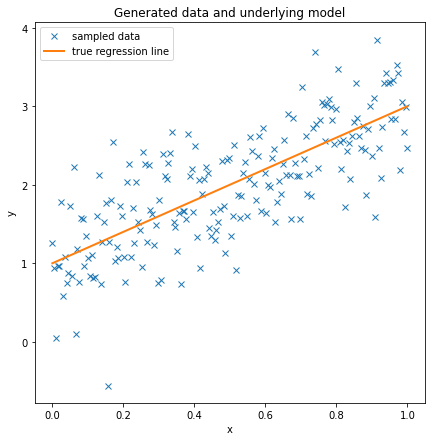

In [2]:
# cell from https://docs.pymc.io/notebooks/GLM-linear.html
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

## model + guide

In [3]:
import logging

import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer import Predictive


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [4]:
def model(x, y=None):
    
    intercept = pyro.sample('intercept', dist.Normal(torch.zeros(1), 20.0 * torch.ones(1)))
    x_coeff = pyro.sample('x_coeff', dist.Normal(torch.zeros(1), 20.0 * torch.ones(1)))
    sigma = pyro.sample('sigma', dist.HalfCauchy(scale=20.0 * torch.ones(1)))
    
    mu_y = intercept + x_coeff * x
    
    # likelihood
    pyro.sample('obs', dist.Normal(mu_y, sigma), obs=y)
    
def guide(x, y=None):
    loc_intercept = pyro.param('loc_intercept', torch.tensor(0.5))
    scale_intercept = pyro.param('scale_intercept', torch.tensor(1.0), constraint=constraints.positive)
    loc_x_coeff = pyro.param('loc_x_coeff', torch.tensor(1.0))
    scale_x_coeff = pyro.param('scale_x_coeff', torch.tensor(1.0), constraint=constraints.positive)
    loc_sigma = pyro.param('loc_sigma', torch.tensor(5.0), constraint=constraints.positive)
    
    intercept = pyro.sample('intercept', dist.Normal(loc_intercept, scale_intercept))
    x_coeff = pyro.sample('x_coeff', dist.Normal(loc_x_coeff, scale_x_coeff))
    sigma = pyro.sample('sigma', dist.Normal(loc_sigma, torch.tensor(0.1)))
    
#     mu_y = intercept + x_coeff * x

## Inference

In [5]:
x = torch.tensor(x)
y = torch.tensor(y)

svi = SVI(
    model,
    guide,
    Adam({'lr': 0.01}),
    loss=Trace_ELBO()
)

pyro.clear_param_store()
num_iters = 5000
for i in range(num_iters):
    elbo = svi.step(x, y)
    if i % 500 == 0:
        logging.info(f'Elbo loss: {elbo}')

Elbo loss: 512.0423595451606
Elbo loss: 169.58144003844177
Elbo loss: 166.47867808251928
Elbo loss: 175.92086940792834
Elbo loss: 168.01859977488033
Elbo loss: 164.39354608080401
Elbo loss: 165.3100864407708
Elbo loss: 163.10224020226076
Elbo loss: 164.00776742248615
Elbo loss: 167.48443894628383


In [6]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(x).items()
               if k != "obs"}

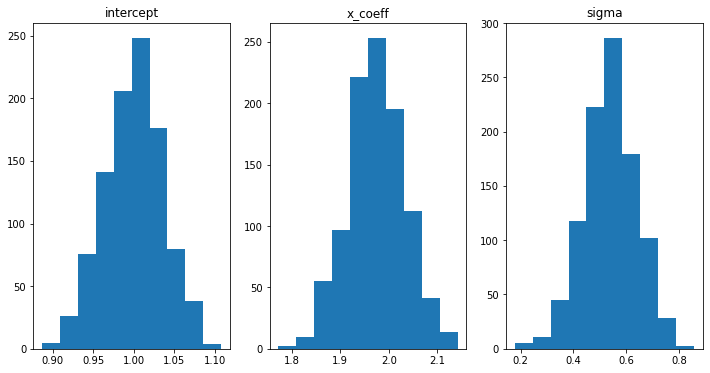

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

for ax, (k, v) in zip(axs, svi_samples.items()):
    ax.hist(v)
    ax.set_title(k)

## wrap up

In [8]:
samples_df = pd.DataFrame(svi_samples)

In [9]:
df = samples_df.sample(5000, replace=True)

In [10]:
bound = map(
    lambda x: df.intercept + df.x_coeff * x + np.random.normal(0, 1, (df.shape[0],)) * df.sigma,
    x.numpy())
bound = map(
    lambda y_pred: np.percentile(y_pred, [2.5, 97.5]),
    bound,
)
bound = np.array(list(bound))

Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


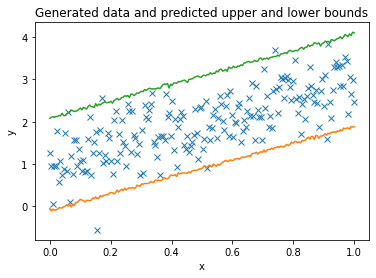

In [11]:
fig, ax = plt.subplots(1, 1)

ax.set_title('Generated data and predicted upper and lower bounds')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.plot(x, y, 'x')
ax.plot(x, bound[:, 0])
ax.plot(x, bound[:, 1]);